# Language Modeling using OpenGRM

- Evgeny A. Stepanov
- stepanov.evgeny.a@gmail.com

This notebook covers Lecture on __Sequence and Language Modeling__ using OpenFST and OpenGRM NGram Library.

__Requirements__

- [OpenFST](http://www.openfst.org/twiki/bin/view/FST/WebHome)
- [OpenGRM](http://www.opengrm.org/twiki/bin/view/GRM/NGramLibrary)
- [NL2SparQL4NLU](https://github.com/esrel/NL2SparQL4NLU) dataset

## 1. Language Modeling Tools

### 1.1. Language Model Building

- Compute n-gram counts from the corpus
- Train LM from the n-gram counts file
- Calculate the test data *perplexity* using LM

<div>
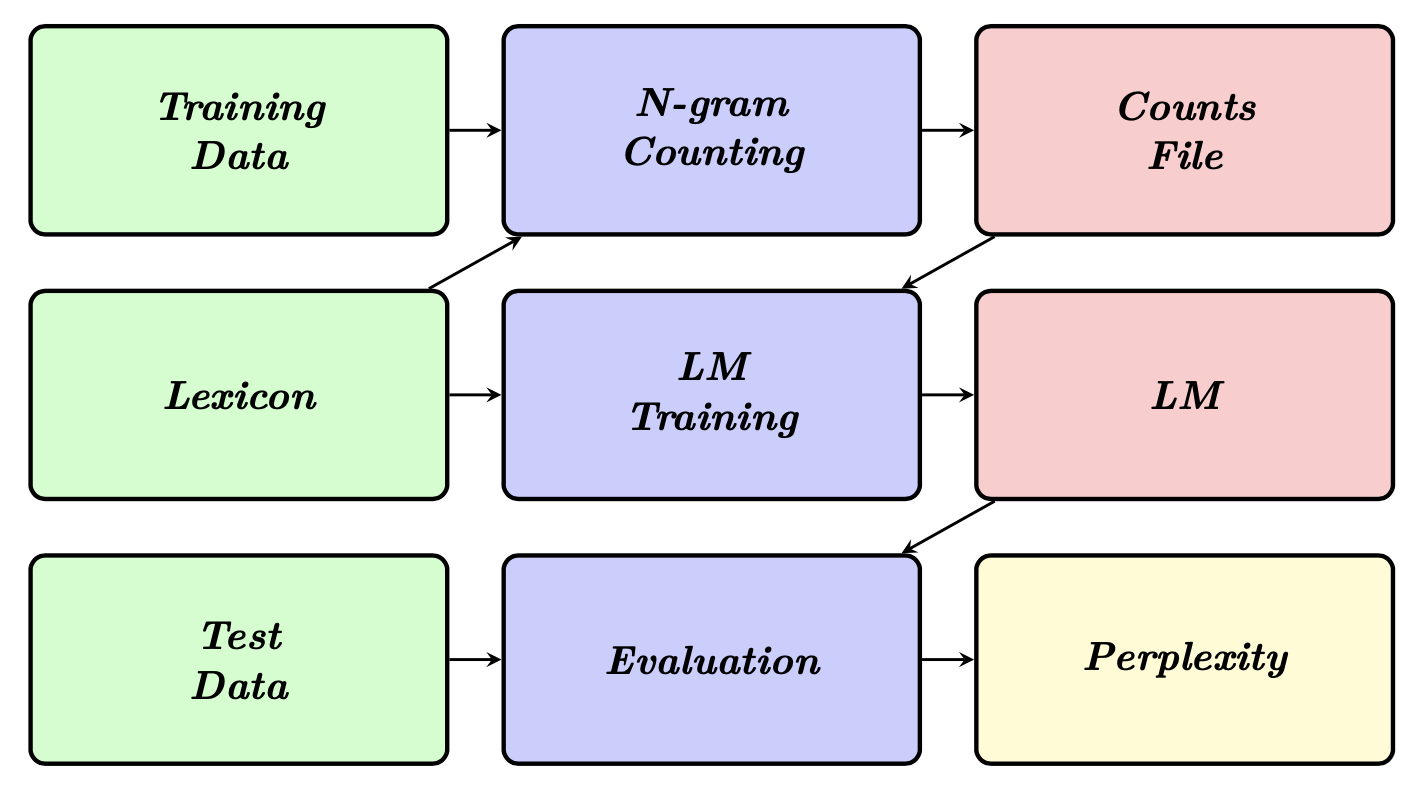
</div>

### 1.2. OpenGRM NGram Library

This functionaly has been implemented in [OpenGRM NGram Library](http://www.opengrm.org/twiki/bin/view/GRM/NGramLibrary) as following commands (blue boxes):

<div>
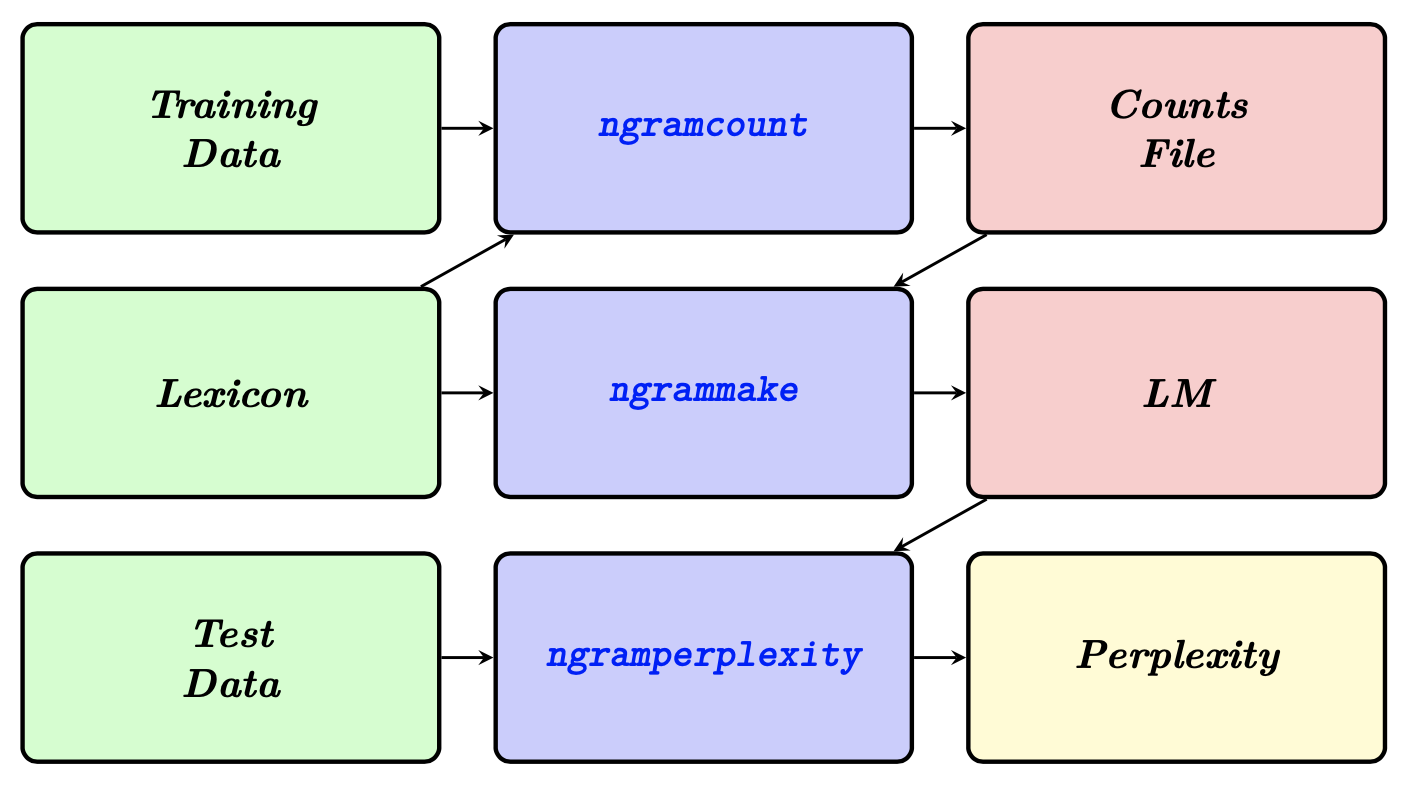
</div>

#### Command-line Tools

| Command             | Description         |
|:--------------------|:--------------------|
| `ngraminfo`         | print various information about an n-gram model
| `ngramread`         | utility to read n-gram models from text file
| `ngramprint`        | utility to write n-gram models to text file
| `ngramsymbols`      | produces a lexicon from an input text corpus
| `ngramcount`        | takes as input a <span style="color: red;">*fst archive*</span>  representing a text input and outputs an *fst* representing counts of n-grams
| `ngrammake`         | takes as input a *counts fst* (the output of `ngramcount`) and outputs an *fst* representing a n-gram back-off stochastic LM
| `ngramapply`        | intersects *n-gram model* with <span style="color: red;">*fst archive*</span>
| `ngramperplexity`   | calculate perplexity of input corpus from model
| `ngramrandgen`      | randomly sample sentences from an n-gram model

Read documentation [here](http://www.opengrm.org/twiki/bin/view/GRM/NGramQuickTour#AvailableOperations) for available options and operations.

__More Advanced Tools__

| Command             | Description         |
|:--------------------|:--------------------|
| `ngrammerge`        | [merges](http://www.opengrm.org/twiki/bin/view/GRM/NGramMerge) two *counts fsts* (the output of `ngramcount`) or two *LMs* (the output of `ngrammake`)
| `ngrammarginalize`  | [impose marginalization constraints](http://www.opengrm.org/twiki/bin/view/GRM/NGramMarginal) on input model
| `ngramshrink`       | n-gram model [pruning](http://www.opengrm.org/twiki/bin/view/GRM/NGramShrink) (e.g. frequency cut-off)

### 1.3. FAR Tools

__FARs__ -- *weighted  finite-state  machines  archives* -- a concatenation of the file representation of one or more finite-state machines.  

Commands:

| Command             | Description         |
|:--------------------|:--------------------|
| `farinfo`           | prints some basic information about the FSTs in an a finite-state archive
| `farcreate`         | creates a finite-state archive from input FSTs
| `farextract`        | extracts FSTs from a finite-state archive
| `farcompilestrings` | compiles a set of strings as FSTs and stores them in a finite-state archive
| `farprintstrings`   | prints as string FSTs in a finite-state archive
| `farequal`          | compares the FSTs in two finite-state archives for equality
| `farisomorphic`     | compares the FSTs in two finite-state archives for [isomorphism](https://en.wikipedia.org/wiki/Isomorphism)



Refer to [manual](http://www.openfst.org/twiki/bin/view/FST/FstExtensions\#FstArchives) for options.

### 1.4. Example 

__Input__: corpus in sentence per line format


#### 1.4.1. Language Model Building

##### Algorithm

1. create lexicon of the corpus
2. compile corpus into FST archive
3. count n-grams (let's do trigram language model)
4. make language model applying smoothing method (let's do Witten-Bell)


In [1]:
%%bash
corpus=NL2SparQL4NLU/dataset/NL2SparQL4NLU.train.utterances.txt
fname=NL2SparQL4NLU

ngramsymbols < $corpus > $fname.lex

farcompilestrings --symbols=$fname.lex --keep_symbols $corpus > $fname.far 

ngramcount --order=3 $fname.far > $fname.counts

ngrammake --method=witten_bell $fname.counts > $fname.lm

#### 1.4.2. Sequence Generation

As we have already seen, LM can be used as automaton to generate strings. 

The regular expression below is added to clean the output (ignore).

```bash
sed 's/<epsilon>//g;s/  */ /g'
```

In [2]:
%%bash
fname=NL2SparQL4NLU
ngramrandgen $fname.lm | farprintstrings | sed 's/<epsilon>//g;s/  */ /g'

check movie information for the producer


### 1.5. Language Model Building Options

`ngrammake` takes a `--method` argument, which specifies smoothing method to be used. Besides "witten_bell", the implemented methods are the listed below (see `--method` option). 

- Absolute
- Witten-Bell
- Kneser-Ney
- Katz
- presmoothed
- unsmoothed

- katz_frac (<span style="color: red;">undocumented</span>)

You cat get further details [here](https://www.aclweb.org/anthology/P96-1041.pdf).

Other arguments are given by `ngrammake --help`


```bash
Make n-gram model from input count file.

  Usage: ngrammake [--options] [in.fst [out.fst]]

PROGRAM FLAGS:

  --backoff: type = bool, default = false
  Use backoff smoothing (default: method dependent)
  --backoff_label: type = int64, default = 0
  Backoff label
  --bins: type = int64, default = -1
  Number of bins for katz or absolute discounting
  --check_consistency: type = bool, default = false
  Check model consistency
  --count_of_counts: type = std::string, default = ""
  Read count-of-counts from file
  --discount_D: type = double, default = -1
  Absolute discount value D to use
  --interpolate: type = bool, default = false
  Use interpolated smoothing (default: method dependent)
  --method: type = std::string, default = "katz"
  One of: "absolute", "katz", "kneser_ney", "presmoothed", "unsmoothed", "katz_frac", "witten_bell"
  --norm_eps: type = double, default = 0.001
  Normalization check epsilon
  --witten_bell_k: type = double, default = 1
  Witten-Bell hyperparameter K
```

### 1.6. [Ngram Model Format](http://www.opengrm.org/twiki/bin/view/GRM/NGramModelFormat) in OpenGRM

- An n-gram is a sequence of k symbols: $w_1 ... w_k$. Let $N$ be the set of n-grams in the model.

- There is a __unigram__ state in every model, representing the __empty string__.
- Every proper prefix of every n-gram in $N$ has an associated state in the model.
- The state associated with an n-gram $w_1 ... w_k$ has a backoff transition (labeled with `<epsilon>`) to the state associated with its suffix $w_2 ... w_k$.
- An n-gram $w_1 ... w_k$ is represented as a transition, labeled with $w_k$, from the state associated with its prefix $w_1 ... w_{k-1}$ to a destination state defined as follows:
    - If $w_1 ... w_k$ is a proper prefix of an n-gram in the model, then the destination of the transition is the state associated with $w_1 ... w_k$
    - Otherwise, the destination of the transition is the state associated with the suffix $w_2 ... w_k$.
- Start and end of the sequence are not represented via transitions in the automaton or symbols in the symbol table. Rather:
    - The start state of the automaton encodes the "start of sequence" n-gram prefix (commonly denoted `<s>`).
    - The end of the sequence (often denoted `</s>`) is included in the model through state final weights, i.e., for a state associated with an n-gram prefix $w_1 ... w_k$, the final weight of that state represents the weight of the n-gram $w_1 ... w_k$ `</s>`.

## 2. Exercises

- Read Tool Manuals (for available tools and their options; they start with `far`, `ngram` and `fst`)

- Pre-process training and test sets to:
    - add sentence begin & end tags
    - handle unknown words (e.g. frequency cut-off)
    
- Convert corpus and lexicon to OpenGRM format

- Train different language models (LM) on the training set of `NL2SparQL4NLU` using OpenGRM NGram Library

    - vary n-gram order
    - vary smoothing
    - compute LM perplexity on the test set

- Report order & smoothing method with lowest perplexity

- Compute scores for utterances in the test set
- Compare scores to the ones computed manually


## 3. Language Model Automaton

*Next Lab Preview*

Let's visualize a toy (much smaller) LM to see the automaton. 

The output of the last command is visualized via [this site](http://www.webgraphviz.com/).

In [3]:
%%bash
fname=toy

cat > $fname.txt <<EOF
the cat is fat
the dog is not
EOF

ngramsymbols < $fname.txt > $fname.lex

farcompilestrings --symbols=$fname.lex --keep_symbols $fname.txt > $fname.far 

ngramcount --order=3 $fname.far > $fname.counts

ngrammake --method=witten_bell $fname.counts > $fname.lm

fstdraw --acceptor --isymbols=$fname.lex $fname.lm


digraph FST {
rankdir = LR;
size = "8.5,11";
center = 1;
orientation = Landscape;
ranksep = "0.4";
nodesep = "0.25";
1 [label = "1", shape = circle, style = bold, fontsize = 14]
	1 -> 0 [label = "<epsilon>/1.0986", fontsize = 14];
	1 -> 3 [label = "the/0.31015", fontsize = 14];
0 [label = "0/1.6094", shape = doublecircle, style = solid, fontsize = 14]
	0 -> 2 [label = "the/1.6094", fontsize = 14];
	0 -> 4 [label = "cat/2.3026", fontsize = 14];
	0 -> 6 [label = "is/1.6094", fontsize = 14];
	0 -> 8 [label = "fat/2.3026", fontsize = 14];
	0 -> 10 [label = "dog/2.3026", fontsize = 14];
	0 -> 13 [label = "not/2.3026", fontsize = 14];
2 [label = "2", shape = circle, style = solid, fontsize = 14]
	2 -> 0 [label = "<epsilon>/0.69315", fontsize = 14];
	2 -> 5 [label = "cat/1.204", fontsize = 14];
	2 -> 11 [label = "dog/1.204", fontsize = 14];
3 [label = "3", shape = circle, style = solid, fontsize = 14]
	3 -> 2 [label = "<epsilon>/0.69315", fontsize = 14];
	3 -> 5 [label = "cat/0.91629", fontsi

<div>
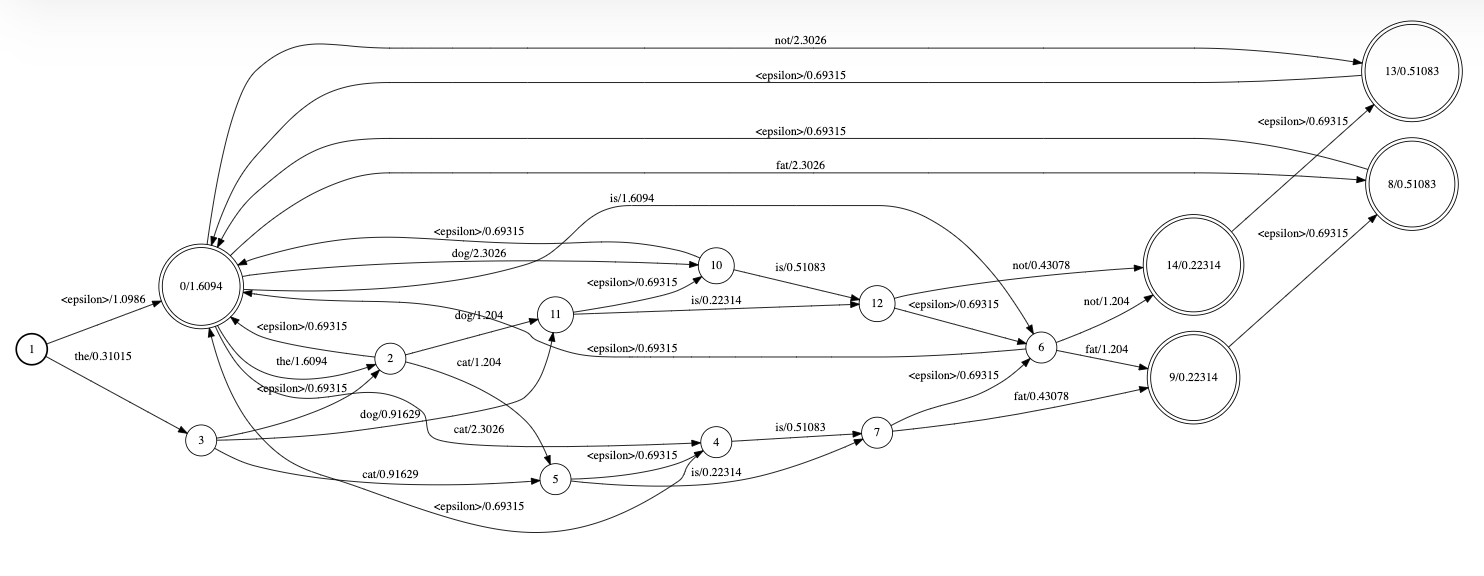
</div>

## A. Appendix

[OpenGRM Ngram Library]() provides some additional command-line tools, which are not documented on the website.

__Undocumented Tools__

| Command             | Description         |
|:--------------------|:--------------------|
| `ngramsplit`        | Split an n-gram model using context patterns.
| `ngramcontext`      | Generates a context set from an input LM.
| `ngramsort`         | Sorts an ngram LM in lexicographic state context order.
| `ngramtransfer`     | Transfer n-grams between models.
| `ngramhisttest`     | Compiles and tests equality of HistogramArc models.
| `ngramrandtest`     | Generates random data/models.